# GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [2]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph

graph_aug_val = Compose([KNNGraph(k=6)])

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

print(len(train_loader))
print(len(val_loader))

308
76


In [3]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCN.ckpt"),WIDTH=32)
model.eval()
model.requires_grad_(False)
print(model.predictor)

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.0, inplace=False)
  (5): Linear(in_features=32, out_features=4, bias=True)
)


---
## Dataset Metrics

In [4]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


Training Loss tensor(0.3235)
Validation Loss tensor(0.5943)
Training Accuracy tensor(0.9221)
Validation Accuracy tensor(0.8158)
Training Cancer Accuracy tensor([0.9708])
Validation Cancer Accuracy tensor([0.8816])


---

### Get Raw Activations

In [5]:

# Attach the hook

batch = next(iter(train_loader))
raw_activations = torch.zeros(0,32)

def append_raw_activations(self, input, output):
    global raw_activations
    raw_activations = torch.cat((raw_activations,output),dim=0)



model.gnn.conv[-1].register_forward_hook(append_raw_activations)



In [6]:
# Acquire the activations
raw_activations = torch.zeros(0,32)

for batch in train_loader:
    model(batch.x,batch.edge_index,batch.batch)
    
#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)

In [7]:
print(raw_activations.shape)

torch.Size([280840, 32])


---
# K Means

In [8]:
def nearest_mean(x,means):

    delta = (means - x)**2
    dists = delta.sum(axis=1)
    return dists.argmin()

def cluster(obs,means,k):
    clusters = [[] for i in range(k)]
    for i,x in enumerate(obs):
        clusters[nearest_mean(x,means)].append(i)
    return clusters


In [9]:

from scipy.cluster.vq import kmeans
import numpy as np
k = 4

tsne_size = 5000

obs = raw_activations.detach().numpy()
mu,sigma = obs.mean(axis=0),obs.std(axis=0)


def whiten(obs):
    return (obs - mu)/sigma

obs_white = whiten(obs)
means,_ = kmeans(obs_white,k_or_guess=k)

#clusters = cluster(obs_white,means,k)

obs = obs[np.random.choice(np.arange(len(obs)),size=tsne_size,replace=False)]
obs_white = whiten(obs)

clusters = cluster(obs_white,means,k)


In [10]:
print(list(map(len,clusters)))

[1541, 1620, 529, 1310]


---
# Vizualize Explanations

In [11]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA



t =TSNE(n_components=2,learning_rate ='auto',init="pca",verbose=1,perplexity = 50,n_iter=2000).fit_transform(obs_white)
#reducer = PCA(n_components=2).fit(obs)
#reducer = KernelPCA(n_components=2,kernel="rbf",degree=2).fit(smaller_obs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.775426


d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.496880
[t-SNE] KL divergence after 2000 iterations: 1.088428


In [12]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_clusters(cluster_ids,values):
    colours = cm.rainbow(np.linspace(0,1,len(cluster_ids)))
    for i,clust_ids in enumerate(cluster_ids):
        v = values[clust_ids]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])


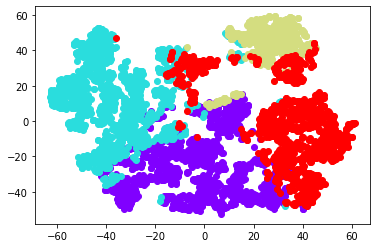

In [13]:
plot_clusters(clusters,t) # clusters and t must be whitened
plt.show()

---
# Concept Completeness

In [14]:
# Activation Graph to Concept Graph


# Attach the hook

activations = []

def save_activation_graph(self, input, output):
    global activations
    activations.append(output)



model.gnn.conv[-1].register_forward_hook(save_activation_graph)



In [15]:
from torch.nn.functional import one_hot

def activation_to_concept(activation):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy()).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_concept_graph(graph):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return activation_to_concept_graph(ag)



In [36]:

from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data

def vizualize_concept_graph(graph):
    print(graph.y)
    x = predict_concept_graph(graph)
    edge_index  = graph.edge_index
    pos = {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}
    colours = cm.rainbow(np.linspace(0,1,k))
    node_colours = [colours[i] for i in x.argmax(dim=1)]
    
    g = Data(x=x,edge_index=edge_index,pos=pos)
    G = to_networkx(graph,to_undirected=True)

    f,ax = plt.subplots(1,1,figsize=(70,70))
    nx.draw(G,pos=pos,node_color=node_colours,node_size=500)
    plt.show()

tensor([2])


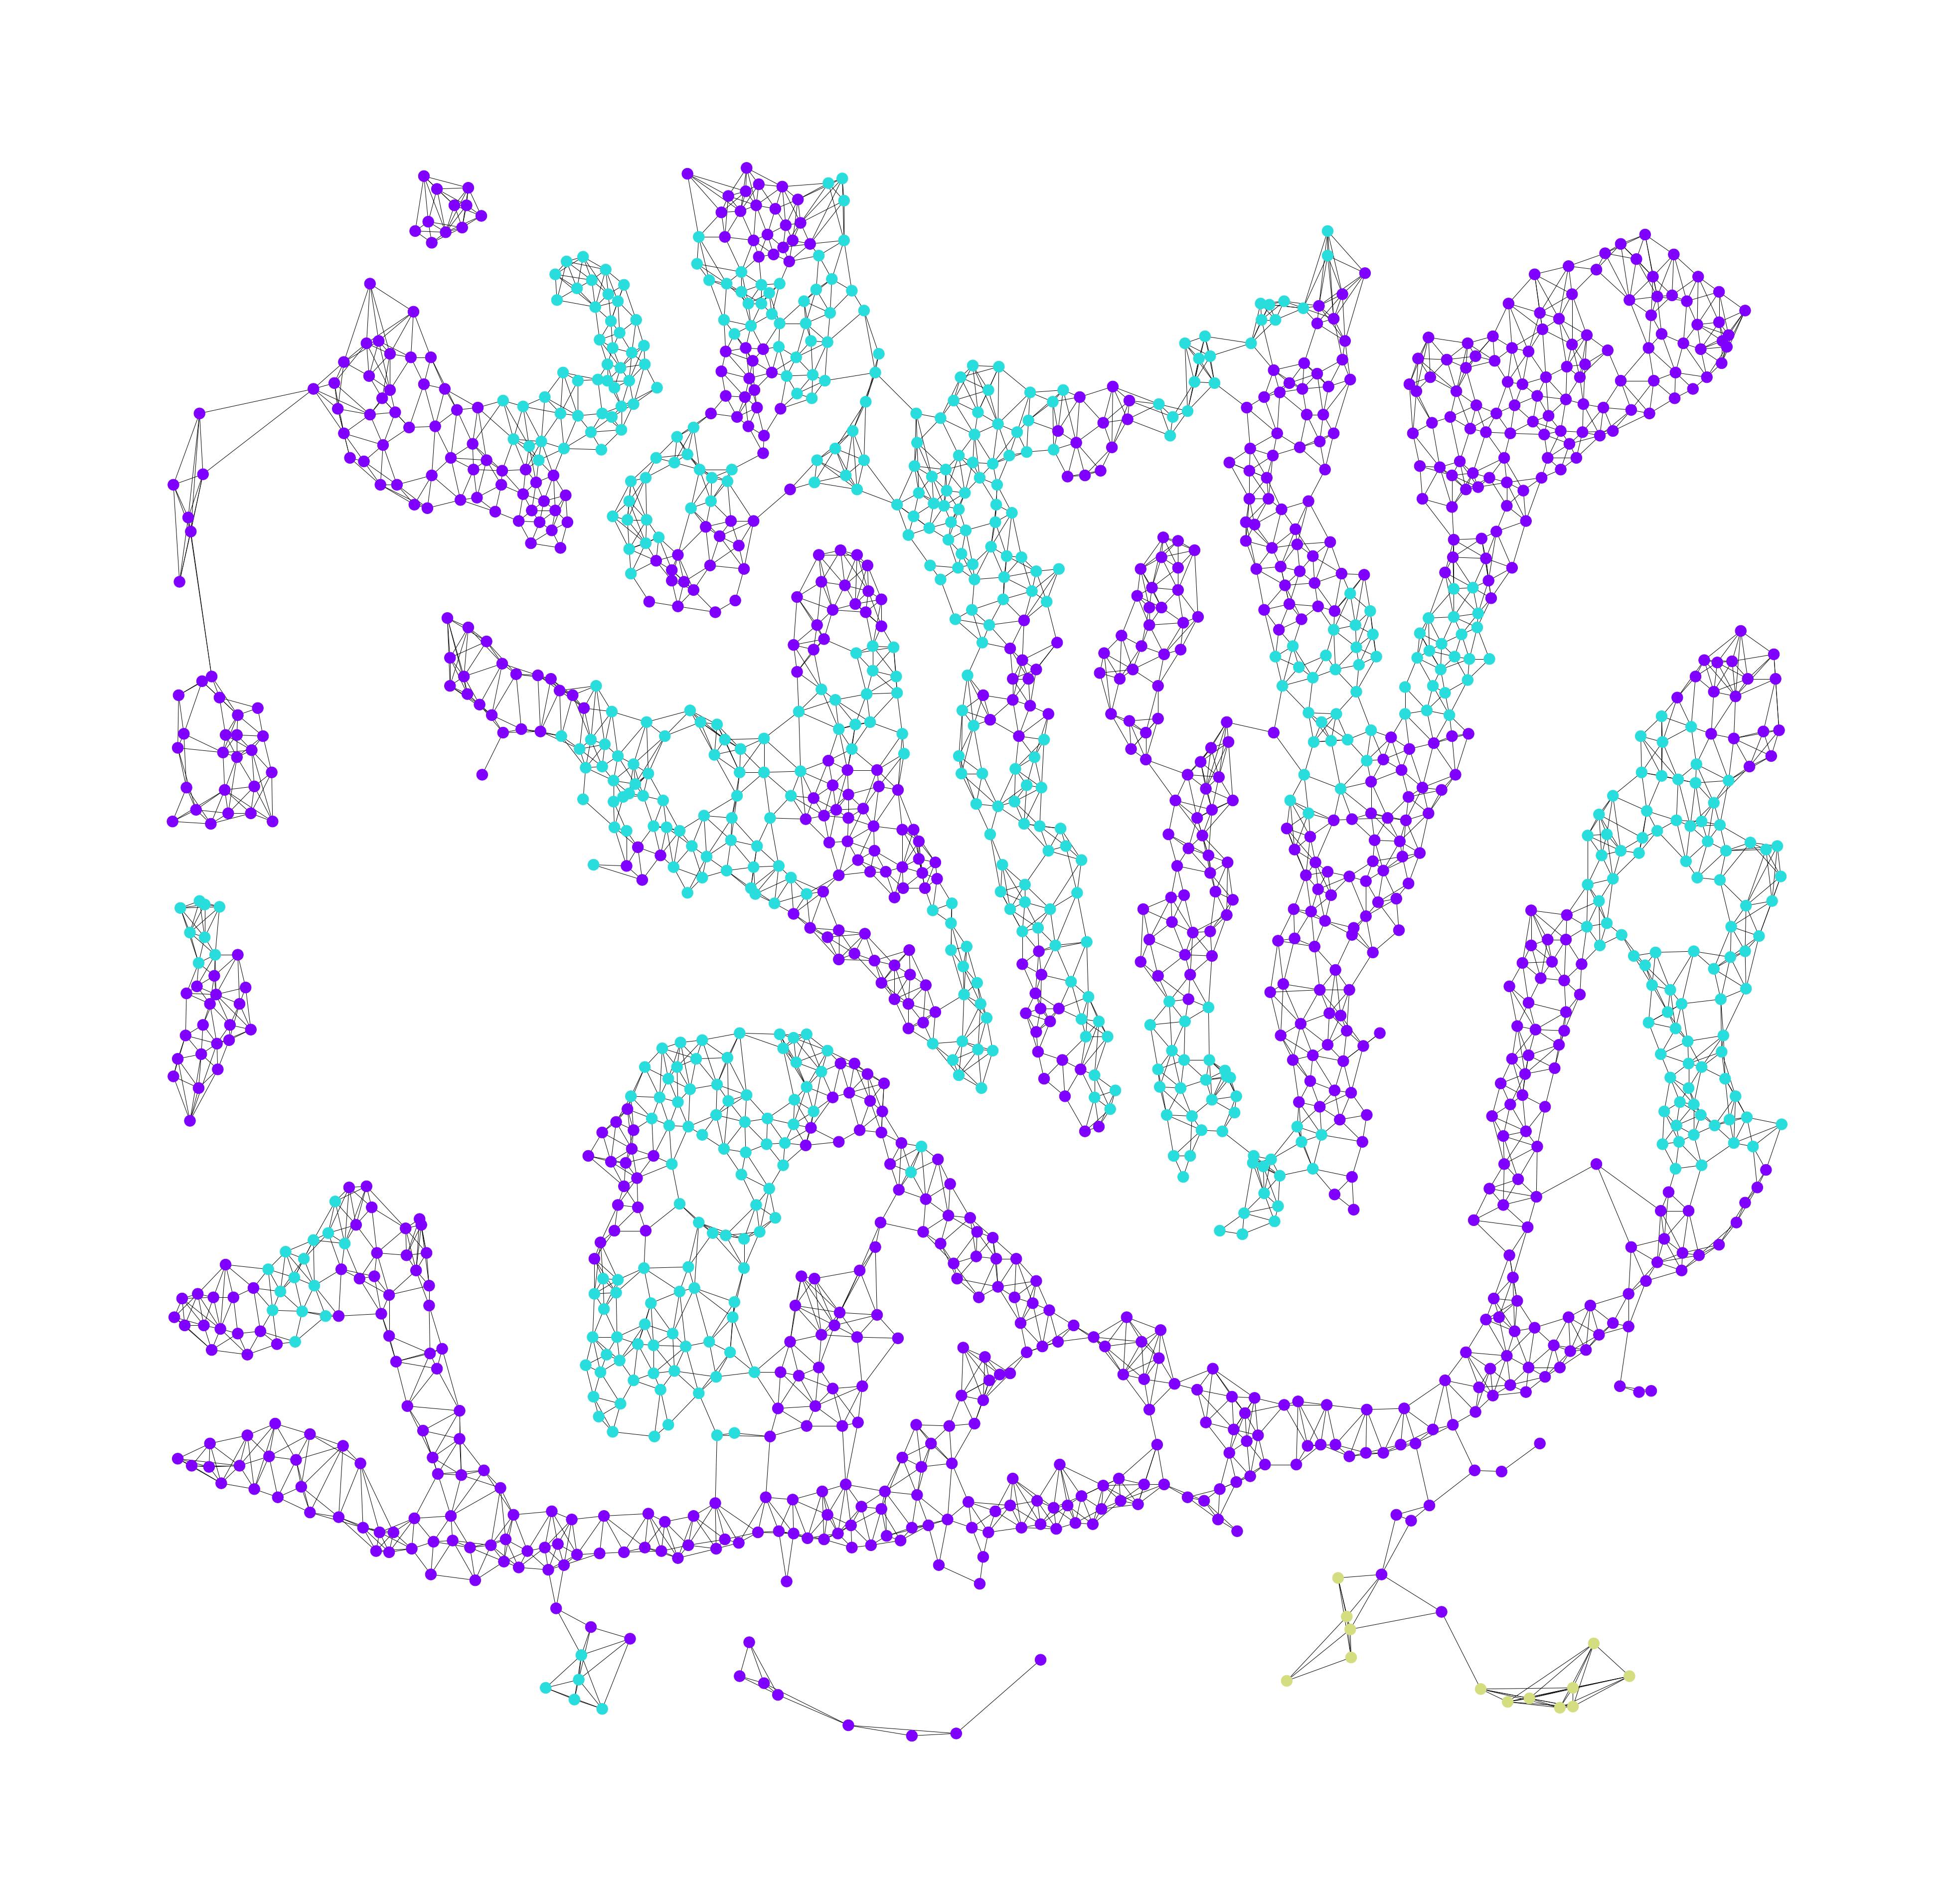

In [43]:
vizualize_concept_graph(next(iter(train_loader)))

---

In [18]:
def concept_vs_cancer(loader): return [(predict_concept_graph(batch).mean(dim=0),batch.y) for batch in loader]

In [19]:
x_train = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(train_loader))))
y_train = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(train_loader))))

x_val = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(val_loader))))
y_val = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(val_loader))))

In [20]:
def plot_agg_concept_for_class(cls,x,y):
    f = plt.figure(figsize=(20,10))
    ind = y==cls
    assert len(x) == len(y)

    plt.imshow(x[ind].reshape(k,-1))


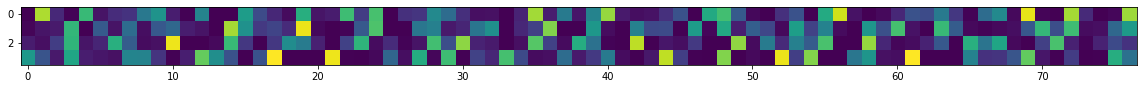

In [21]:
plot_agg_concept_for_class(1,x_train,y_train)

In [22]:
torch.as_tensor(x_train).max(dim=0)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 0.9811], dtype=torch.float64),
indices=tensor([243,  42, 264,  38]))

---
### CBE

1.0
0.2631578947368421


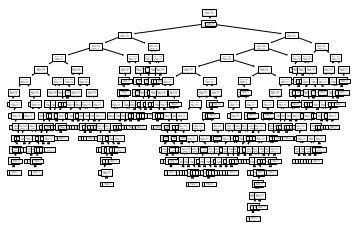

In [23]:
## Linear Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree
l = tree.DecisionTreeClassifier(splitter="random",criterion="entropy",max_depth=20).fit(x_train,y_train)

tree.plot_tree(l)

print((l.predict(x_train) == y_train).mean())
print((l.predict(x_val) == y_val).mean())



In [24]:
import sklearn.tree as tree

dectree = tree.DecisionTreeClassifier(max_depth=5,criterion="entropy").fit(x_train,y_train)

pass

In [25]:
(dectree.predict(x_train) == y_train).mean()

0.4935064935064935

In [26]:
(dectree.predict(x_val) == y_val).mean()

0.27631578947368424